匯入套件

In [304]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

定義模型架構

In [305]:
# Plotting Class
class Plotting:
    # Constructor initialize the model(get model from NeuralNetwork class)
    def __init__(self, model):
        self.model = model

    def trainLoss_plot(self):
        plt.plot(self.model.rmse_list)
        plt.xlabel('Epochs')
        plt.ylabel('RMSE')
        plt.title('RMSE over epochs')
        plt.show()

    # defined regression classify function
    def predict_plot(self, mode):
        # get model's df and turn (predict_df, true_df) to ndarray (by values.ravel())
        predict = self.model.predict_df.values
        true = self.model.true_df.values

        # If the mode is one-hot encoding, create a binary scatter plot for each class
        if mode == 'one_hot_encoding':
            for i in range(true.shape[1]):
                plt.figure()
                plt.scatter(range(len(true)), true[:, i], label='true', alpha=0.5)
                plt.scatter(range(len(predict)), predict[:, i], label='predict', alpha=0.5)
                plt.xlabel('Number of Samples')
                plt.ylabel('Class Probability')
                plt.title(f'{mode}: Predict vs True for Class {i+1}')
                plt.legend()
                plt.show()
        elif mode == 'regression':
            # Create a color map
            colors = {1:'red', 2:'green', 3:'blue'}
            # Create a scatter plot with different colors for each class
            plt.scatter(true, predict, c=[colors[i[0]] for i in true])
            plt.xlabel('True_class')
            plt.ylabel('Predict_class')
            plt.title(f'{mode}: Predict vs True for Class')
            plt.show()
        else:
            print('Invalid mode. Please enter one_hot_encoding or regression')
            return

定義激活函式 (方便未來更改)

In [306]:
# Activation Functions Class
class ActivationFunctions:
    # Constructor static methods
    @staticmethod
    def purelin(x):
        return x

    @staticmethod
    def dpurelin(x):
        return np.ones_like(x)

    @staticmethod
    def logsig(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def dlogsig(x):
        fx = ActivationFunctions.logsig(x)
        return fx * (1 - fx)

In [307]:
class ProcessedDataset:
    def __init__(self, mode):
        self.mode = mode
        # load dataset
        self.input_dataset = pd.read_csv('./datasets/iris_in.csv', header=None)
        self.output_dataset = pd.read_csv('./datasets/iris_out.csv', header=None)
        if self.mode == 'one_hot_encoding': 
            self.one_hot_encoding()
            print(f'現在是{self.mode}模式')
        elif mode == 'regression':
            print(f'現在是{self.mode}模式')
        else:
            raise ValueError(f'Invalid mode: {self.mode}, 請重新輸入正確的mode')

    def one_hot_encoding(self):
        # 將資料轉換為 one-hot 編碼
        self.output_dataset = pd.get_dummies(self.output_dataset[0]).astype(int)
        
    def get_processedDatasets(self):
        return self.input_dataset, self.output_dataset

In [308]:
# Neural Network Class
class NeuralNetwork:
    # Constructor initialize the hyperparameters & weights & rmse_list
    def __init__(self, n, split_ratio, epochs, learning_rate, mode = 'regression'):

        # Initialize Plotting class (Delegation plot function to Plotting class)
        # Help me to change plot's ways in the future
        self.plotting = Plotting(self)
        
        # Initialize all activation Functions 
        # from ActivationFunctions class to get activation functions
        # Help me to pass function_variable to other functions
        self.purelin = ActivationFunctions.purelin
        self.dpurelin = ActivationFunctions.dpurelin
        self.logsig = ActivationFunctions.logsig
        self.dlogsig = ActivationFunctions.dlogsig

        self.mode = mode

        # Initialize load_dataset function
        processedDataset_model = ProcessedDataset(mode)
        self.input_data, self.output_data = processedDataset_model.get_processedDatasets()

        # get Hyperparameters
        self.n = n
        self.split_ratio = split_ratio
        self.epochs = epochs
        self.learning_rate = learning_rate
        # Initialize rmse_list
        self.rmse_list = []

    def load_dataset(self):
        # # load dataset
        # self.input_data = pd.read_csv('./datasets/iris_in.csv', header=None)
        # self.output_data = pd.read_csv('./datasets/iris_out.csv', header=None)

        # get split dataset ratio(eq: train: 50%, test: 50%)
        self.idx = int(len(self.input_data) * self.split_ratio)
        # train dataset
        self.train_x = self.input_data.iloc[:self.idx, :]
        self.train_y = self.output_data.iloc[:self.idx, :]
        # test dataset
        self.test_x = self.input_data.iloc[self.idx:, :]
        self.test_y = self.output_data.iloc[self.idx:, :]

        # get input_size
        input_size = len(self.train_x.columns)
        # get input_size
        output_size = len(self.train_y.columns)

        # Initialize weights
        self.w_out = np.random.rand(self.n, output_size)*2-1
        self.w_hid = np.random.rand(input_size, self.n)*2-1

    # defined forward propagation function
    def forward_propagation(self, input_vector):

        # pls check the shape of input_vector shape needs(1,4), ex: 4 = features(input_sizes)
        sum_hid = input_vector @ self.w_hid #(1,4)@(4,n) = (1,n)
        a_hid = self.logsig(sum_hid) #(1,n) n=hidden layer node number

        sum_out = a_hid @ self.w_out #(1,n) @ (n,output_size) = (1, output_size)
        a_out = self.purelin(sum_out) # (1, output_size)

        return a_hid, a_out
    
    # defined back propagation function
    def Back_propagation(self, error_vector, a_out, a_hid, input_vector, learning_rate):
        # for example output_size = 3
        # error shape = (1,output_size), =(1,3)
        # get Delta_out and Delta_hid 
        Delta_out = (error_vector) * self.dpurelin(a_out) #(1,output_size)*(1,output_size) = (1,output_size)
        Delta_hid = Delta_out @ self.w_out.T #(1,output_size)@ (output_size,n) = (1,n)

        # update weights
        # 1.weight_out
        self.w_out += learning_rate * a_hid.T @ Delta_out #(n,output_size) + lr* (n,1) @ (1,output_size) = (n,output_size)

        # 2.weight_hid
        self.w_hid += learning_rate * input_vector.T @ (Delta_hid * self.dlogsig(a_hid)) #(input_sizes,n) + lr* (input_sizes,1) @ [(1,n)*(1,n)] = (input_sizes,n)

        # return updated weights
        return self.w_out, self.w_hid
    
    # defined train function
    def train(self):
        # iterate epochs times(and then we will run down all training process)
        for epoch in range(self.epochs):
            # iterate over each training data and update weights
            mse_list = [self.train_step(i) for i in range(len(self.train_x))]
            # append the rmse of each epoch to rmse_list
            self.rmse_list.append(np.sqrt(np.mean(mse_list)))     
            # print the epoch and rmse
            print(f'Epoch: {epoch+1}, RMSE: {self.rmse_list[-1]:.4f}')
    
    # defined train_step function (run over each training data and update weights is one epoch)
    def train_step(self,i):
        # get input vector(也就是input_data的每一筆數據, reshape成(1,features=input_sizes))
        input_vector = np.array(self.train_x.iloc[i]).reshape(1, -1) # (1, input_sizes)
        # do forward propagation(得到a_hid, a_out)
        a_hid, a_out = self.forward_propagation(input_vector)

        # get true_value and pred_value
        true_vector = np.array(self.train_y.iloc[i]).reshape(1, -1) # (1, output_size)

        pred_vector = a_out   # (1, output_size)

        error_vector = true_vector - pred_vector # (1, output_size)
        
        # do back propagation(利用error去更新權重w_out, w_hid)
        self.w_out, self.w_hid = self.Back_propagation(error_vector, a_out, a_hid, input_vector, self.learning_rate)
        
        return np.square(error_vector).sum()
    
    # defined predict function and return predict_df and true_df
    def predict(self):
        _, predict_value = self.forward_propagation(self.test_x) #return a_out就好
        self.predict_df = pd.DataFrame(predict_value)  # pred true (turn to dataframe from tuple)
        self.true_df = self.test_y # ground true (test_y)
        return self.predict_df, self.true_df
    
    def save_df(self, mode):
        if mode == 'one_hot_encoding':
            self.predict_df.to_csv(f'./result/predict({mode}).csv', index=False, header=None)
            self.true_df.to_csv(f'./result/true({mode}).csv', index=False, header=None)
        elif mode == 'regression':
            self.predict_df.to_csv(f'./result/predict({mode}).csv', index=False, header=None)
            self.true_df.to_csv(f'./result/true({mode}).csv', index=False, header=None)
        else:
            raise ValueError(f'Invalid mode: {mode}, 請重新輸入正確的mode')

    # use Plotting class to plot loss and predict
    def loss_plot(self):
        self.plotting.trainLoss_plot()
    
    def result_plot(self):
        self.plotting.predict_plot(self.mode)

In [309]:
# @ = matmul() is matrix multiplication(矩陣相乘)
# * = dot() is element-wise multiplication(元素相乘)

定義超參數

In [310]:
hyperparameters = {
    'n': 20,                 # n: number of hidden neurons
    'split_ratio': 0.5,      # split_ratio: train/test split ratio
    'epochs': 50,          # epochs: number of training epochs
    'learning_rate': 0.05,   # learning_rate: learning rate
    'mode': 'one_hot_encoding' # mode: one_hot_encoding or normal(default)
    
}

執行，並畫圖

In [311]:
# Usage
nn = NeuralNetwork(**hyperparameters)
nn.load_dataset()
nn.train()

現在是one_hot_encoding模式
Epoch: 1, RMSE: 0.8058
Epoch: 2, RMSE: 0.6909
Epoch: 3, RMSE: 0.6672
Epoch: 4, RMSE: 0.6568
Epoch: 5, RMSE: 0.6489
Epoch: 6, RMSE: 0.6419
Epoch: 7, RMSE: 0.6355
Epoch: 8, RMSE: 0.6297
Epoch: 9, RMSE: 0.6245
Epoch: 10, RMSE: 0.6198
Epoch: 11, RMSE: 0.6156
Epoch: 12, RMSE: 0.6118
Epoch: 13, RMSE: 0.6084
Epoch: 14, RMSE: 0.6053
Epoch: 15, RMSE: 0.6025
Epoch: 16, RMSE: 0.6000
Epoch: 17, RMSE: 0.5978
Epoch: 18, RMSE: 0.5957
Epoch: 19, RMSE: 0.5939
Epoch: 20, RMSE: 0.5922
Epoch: 21, RMSE: 0.5906
Epoch: 22, RMSE: 0.5892
Epoch: 23, RMSE: 0.5880
Epoch: 24, RMSE: 0.5868
Epoch: 25, RMSE: 0.5857
Epoch: 26, RMSE: 0.5847
Epoch: 27, RMSE: 0.5838
Epoch: 28, RMSE: 0.5829
Epoch: 29, RMSE: 0.5821
Epoch: 30, RMSE: 0.5814
Epoch: 31, RMSE: 0.5807
Epoch: 32, RMSE: 0.5801
Epoch: 33, RMSE: 0.5795
Epoch: 34, RMSE: 0.5789
Epoch: 35, RMSE: 0.5784
Epoch: 36, RMSE: 0.5779
Epoch: 37, RMSE: 0.5774
Epoch: 38, RMSE: 0.5769
Epoch: 39, RMSE: 0.5765
Epoch: 40, RMSE: 0.5761
Epoch: 41, RMSE: 0.5757
Epo

In [312]:
predict_df, true_df = nn.predict()
nn.save_df('one_hot_encoding')

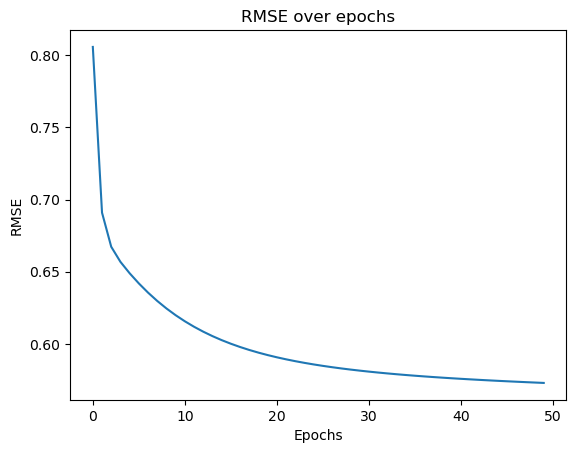

In [313]:
nn.loss_plot()

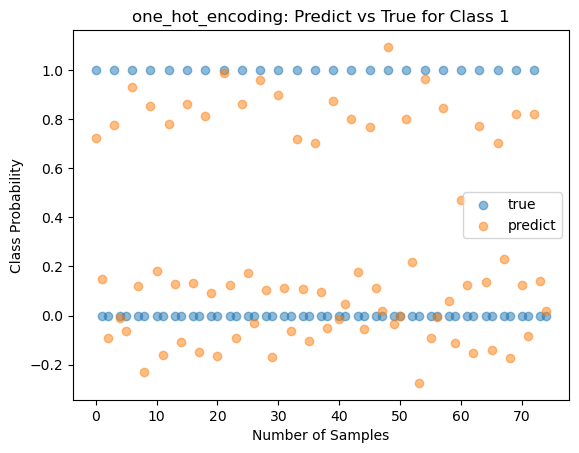

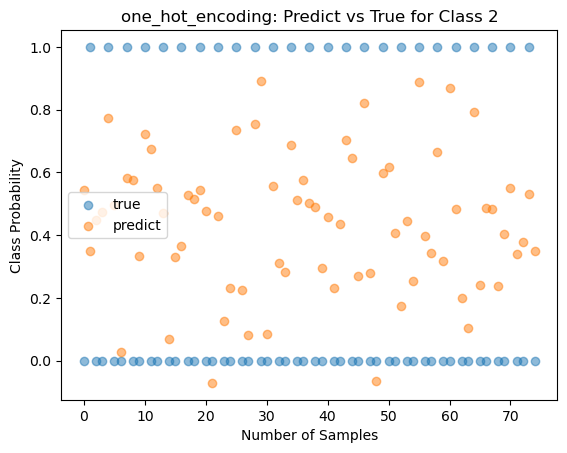

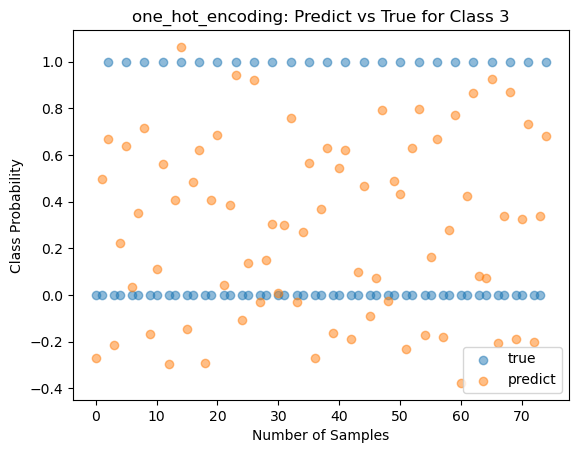

In [314]:
nn.result_plot()